1. plot parity plot
2. make table for database and tasks

- qmof, bandgap (1.9e-2): offline-run-20230705_183638-crssa0mx (0.76678/0.65315) - offline-run-20230705_184905-n47d95vb (0.9283/0.68006)
- qmof, bandgap (3e-2): **offline-run-20230705_191136-29xt07cq** (0.79231/0.67763) - offline-run-20230705_191705-a398zklv (0.94759/0.71159)
                            - **offline-run-20230706_093640-o538n47g** (0.98624/0.71447)
wandb:      task outputs.pbe.bandgap
wandb:  test_mae 0.45394
wandb:  test_mse 0.36495
wandb:   test_r2 0.71447
wandb: train_mae 0.09586
wandb: train_mse 0.01762
wandb:  train_r2 0.98624

- core, kh_co2: **offline-run-20230706_111540-5qdpjzxq** (0.63005/0.24303)

wandb:       task outputs.logKH_CO2
wandb:   test_mae 0.66582
wandb:   test_mse 0.78494
wandb:    test_r2 0.24303
wandb:  train_mae 0.48601
wandb:  train_mse 0.40736
wandb:   train_r2 0.63005

- core, kh_ch4: **offline-run-20230706_112700-krfvi5r4** (0.58837/0.15228)

wandb:       task outputs.logKH_CH4
wandb:   test_mae 0.35083
wandb:   test_mse 0.2032
wandb:    test_r2 0.15228
wandb:  train_mae 0.2345
wandb:  train_mse 0.09073
wandb:   train_r2 0.58837

- therm, T_decomp: **offline-run-20230706_121423-7qgmwgwm** (0.62047/0.27392) - **offline-run-20230706_122358-cu4zlzs6** (0.92092/0.2897)

wandb:      task outputs.assigned_T_d...
wandb:  test_mae 56.69829
wandb:  test_mse 5432.56641
wandb:   test_r2 0.2897
wandb: train_mae 17.5609
wandb: train_mse 566.46442
wandb:  train_r2 0.92092



In [1]:
from mofgraph2vec.data.datamodule import DataModuleFactory
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle
import matplotlib as mpl

mpl.rcParams["font.size"] = 18

In [116]:
doc2vec_path = "offline-run-20230706_111540-5qdpjzxq"
xgboost_path = "offline-run-20230706_111540-5qdpjzxq"

In [84]:
config_qmof = {
        'pretraining': False, 
        'embedding_model_path': None, 
        'task': ['outputs.pbe.bandgap'], 
        'MOF_id': 'qmof_id', 
        'label_path': '../data/qmof-data.csv', 
        'embedding_path': '../experiments/workflow/wandb/%s/tmp/embedding_dv.csv' %doc2vec_path, 
        'train_frac': 0.8, 
        'valid_frac': 0.1, 
        'test_frac': 0.1, 
        'batch_size': 512, 
        'num_workers': 6, 
        'seed': 2234
}

In [117]:
config_core = {
        'pretraining': False, 
        'embedding_model_path': None, 
        'task': ['outputs.logKH_CO2'], 
        'MOF_id': 'info.name', 
        'label_path': '../data/md-core.csv', 
        'embedding_path': '../experiments/workflow/wandb/%s/tmp/embedding_dv.csv' %doc2vec_path, 
        'train_frac': 0.8, 
        'valid_frac': 0.1, 
        'test_frac': 0.1, 
        'batch_size': 512, 
        'num_workers': 6, 
        'seed': 2234
}

In [108]:
config_therm = {
        'pretraining': False, 
        'embedding_model_path': None, 
        'task': ['outputs.assigned_T_decomp'], 
        'MOF_id': 'info.CoRE_name', 
        'label_path': '../data/md-therm.csv', 
        'embedding_path': '../experiments/workflow/wandb/%s/tmp/embedding_dv.csv' %doc2vec_path, 
        'train_frac': 0.8, 
        'valid_frac': 0.1, 
        'test_frac': 0.1, 
        'batch_size': 512, 
        'num_workers': 6, 
        'seed': 2234
}

In [118]:
dmf = DataModuleFactory(**config_core)

2023-07-06 14:46:31.421 | DEBUG    | mofgraph2vec.data.datamodule:__init__:42 - Loading embedded features from ../experiments/workflow/wandb/offline-run-20230706_111540-5qdpjzxq/tmp/embedding_dv.csv
2023-07-06 14:46:32.735 | INFO     | mofgraph2vec.data.datamodule:__init__:68 - Train: 1534 Valid: 171 Test: 190


In [119]:
train_ds = dmf.get_train_dataset()
valid_ds = dmf.get_valid_dataset()
test_ds = dmf.get_test_dataset()

In [120]:
model = pickle.load(open("../experiments/workflow/wandb/%s/tmp/best_model.pkl" %xgboost_path, 'rb'))

In [121]:
train_pred = model.predict(train_ds.vectors)
test_pred = model.predict(test_ds.vectors)

train_true = train_ds.labels.numpy()
test_true = test_ds.labels.numpy()

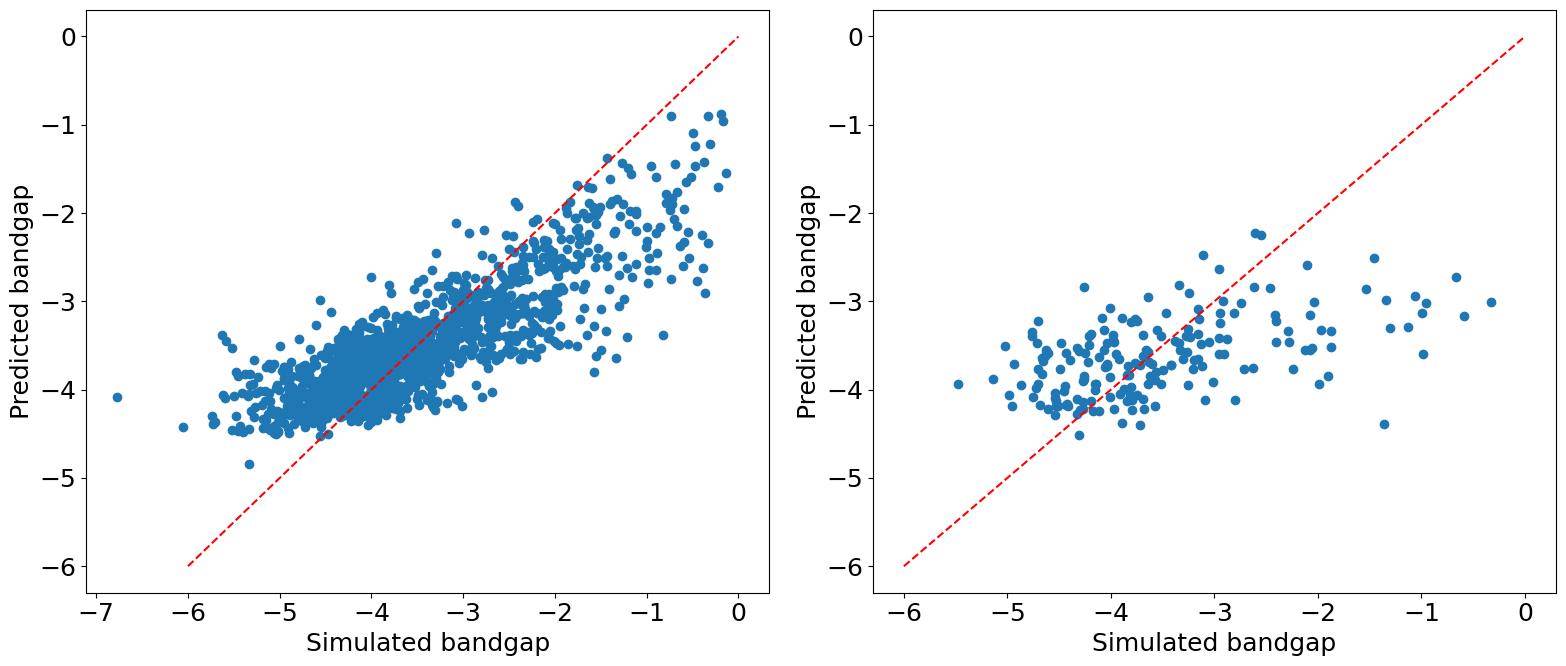

In [122]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,7)

min = -6
max = 0

ax[0].plot([min, max], [min, max], 'r--')
ax[1].plot([min, max], [min, max], 'r--')
ax[0].scatter(train_true, train_pred)
ax[1].scatter(test_true, test_pred)


ax[0].set_xlabel("Simulated bandgap")
ax[1].set_xlabel("Simulated bandgap")
ax[0].set_ylabel("Predicted bandgap")
ax[1].set_ylabel("Predicted bandgap")
fig.tight_layout()

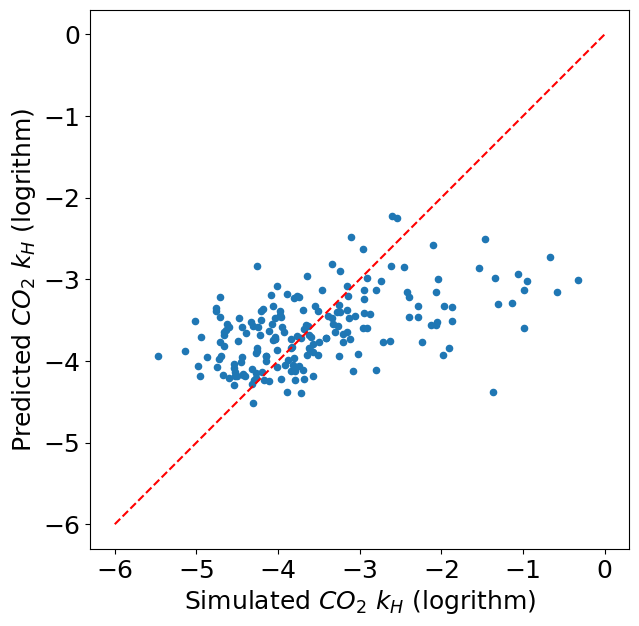

In [123]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,7)

ax.set_aspect('equal', adjustable='box')
ax.plot([min, max], [min, max], 'r--')
ax.scatter(test_true, test_pred, s=20)

# $CH_4\ k_H$ (logrithm)
# (\N{DEGREE SIGN} C)
ax.set_xlabel("Simulated $CO_2\ k_H$ (logrithm)")
ax.set_ylabel("Predicted $CO_2\ k_H$ (logrithm)")

fig.savefig("parity_plots/kh_co2_1.2.png", dpi=1200, bbox_inches='tight')